Установим зависимости: 

In [37]:
import os
import pandas as pd
import psycopg2

from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
load_dotenv("../.env")

True

Подключение к БД


In [38]:
def connect_to_db():
    try:
        conn = psycopg2.connect(
            host="localhost",
            port=os.getenv("POSTGRES_PORT", 5432),
            database=os.getenv("POSTGRES_DB", "online_store"),
            user=os.getenv("POSTGRES_USER", "postgres"),
            password=os.getenv("POSTGRES_PASSWORD", "postgres")
        )
        print("Успешное подключение к базе данных")
        return conn
    except Exception as e:
        print(f"Ошибка подключения: {e}")
        return None

conn = connect_to_db()

Успешное подключение к базе данных


1. Динамика продаж по месяцам


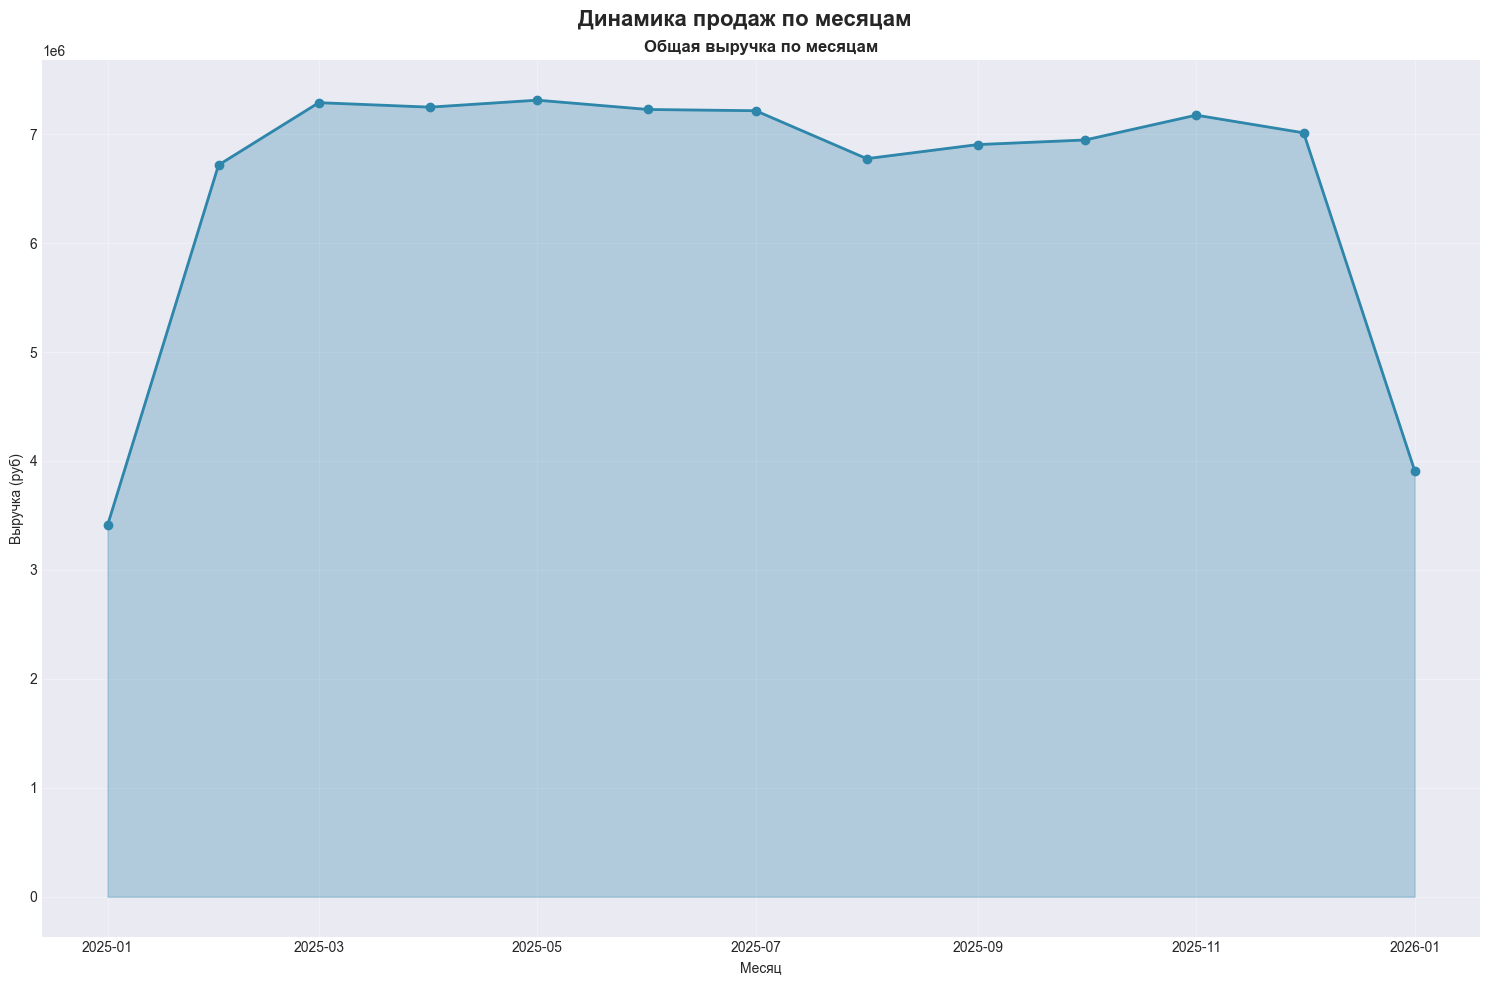

In [39]:
query_monthly_sales = """
SELECT 
    DATE_TRUNC('month', order_date) as month,
    COUNT(*) as orders_count,
    SUM(total_amount) as total_revenue,
    AVG(total_amount) as avg_order_value,
    COUNT(DISTINCT user_id) as unique_customers
FROM orders
GROUP BY DATE_TRUNC('month', order_date)
ORDER BY month;
"""

df_monthly = pd.read_sql(query_monthly_sales, conn)
df_monthly['month'] = pd.to_datetime(df_monthly['month'])

fig, axes = plt.subplots(1, 1, figsize=(15, 10))
fig.suptitle('Динамика продаж по месяцам', fontsize=16, fontweight='bold')

axes.plot(df_monthly['month'], df_monthly['total_revenue'], 
                marker='o', linewidth=2, color='#2E86AB')
axes.fill_between(df_monthly['month'], df_monthly['total_revenue'], 
                        alpha=0.3, color='#2E86AB')
axes.set_title('Общая выручка по месяцам', fontweight='bold')
axes.set_xlabel('Месяц')
axes.set_ylabel('Выручка (руб)')
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

2. Анализ категорий товаров

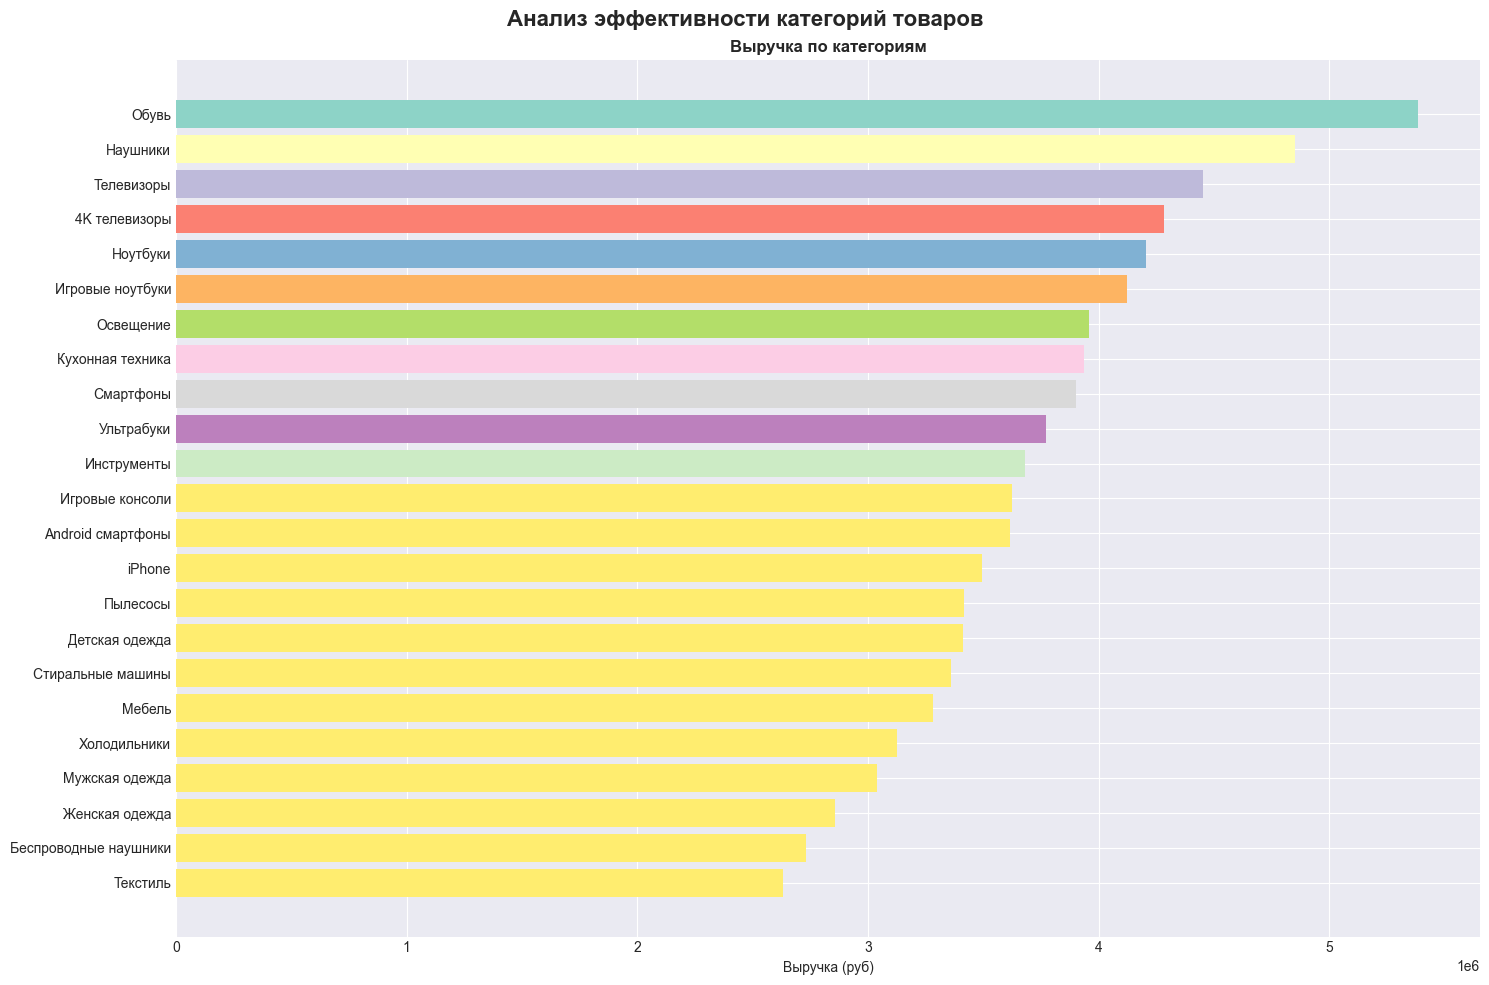

In [40]:
query_categories = """
SELECT 
    c.name as category,
    COUNT(DISTINCT p.id) as products_count,
    COUNT(o.id) as orders_count,
    SUM(o.total_amount) as total_revenue,
    SUM(o.quantity) as total_quantity_sold,
    ROUND(AVG(p.price), 2) as avg_product_price,
    ROUND(CAST(COUNT(o.id) * 100.0 / SUM(COUNT(o.id)) OVER () as numeric), 2) as revenue_share_percent
FROM categories c
LEFT JOIN products p ON c.id = p.category_id
LEFT JOIN orders o ON p.id = o.product_id
GROUP BY c.id, c.name
ORDER BY total_revenue DESC NULLS LAST;
"""

df_categories = pd.read_sql(query_categories, conn)
df_categories = df_categories.fillna(0)

fig, axes = plt.subplots(1, 1, figsize=(15, 10))
fig.suptitle('Анализ эффективности категорий товаров', fontsize=16, fontweight='bold')

bars1 = axes.barh(df_categories['category'], df_categories['total_revenue'], 
                       color=plt.cm.Set3(np.arange(len(df_categories))))
axes.set_xlabel('Выручка (руб)')
axes.set_title('Выручка по категориям', fontweight='bold')
axes.invert_yaxis()

plt.tight_layout()
plt.show()

3. Анализ дней недели и времени покупок

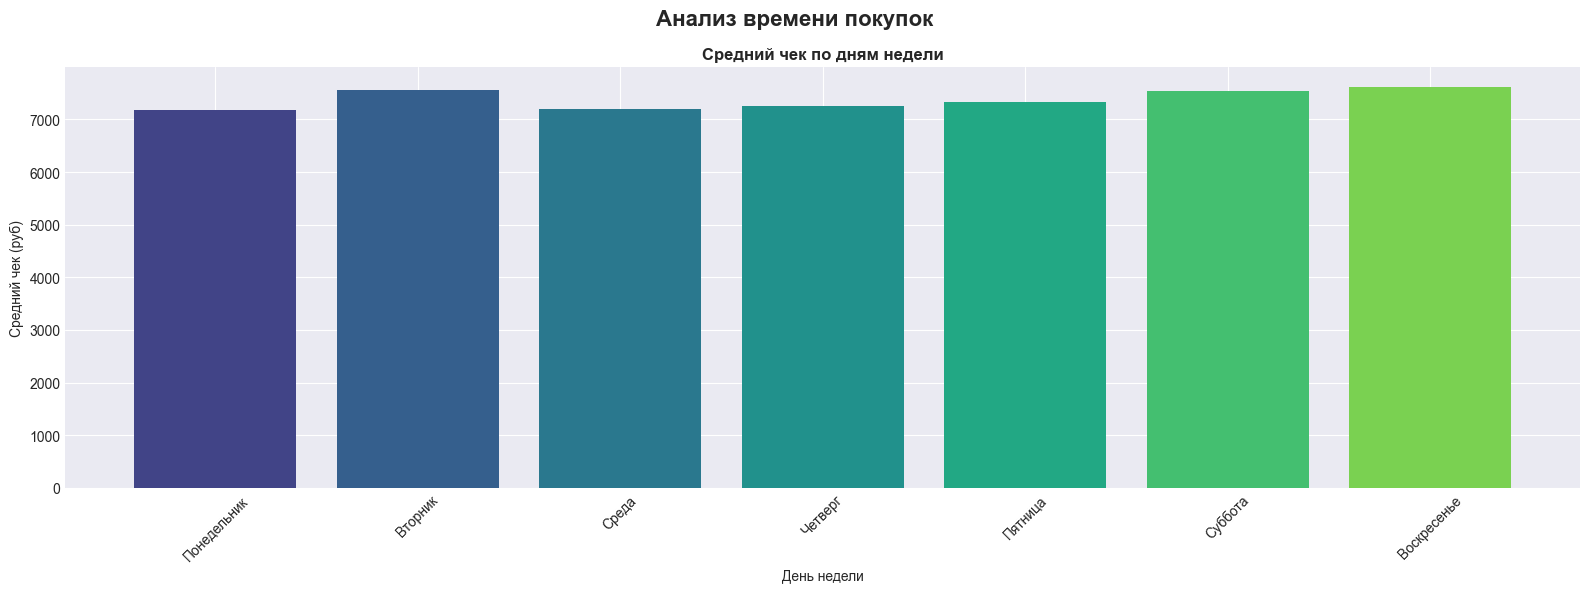

In [41]:
query_time_analysis = """
SELECT 
    EXTRACT(DOW FROM order_date) as day_of_week_num,
    CASE EXTRACT(DOW FROM order_date)
        WHEN 0 THEN 'Воскресенье'
        WHEN 1 THEN 'Понедельник'
        WHEN 2 THEN 'Вторник'
        WHEN 3 THEN 'Среда'
        WHEN 4 THEN 'Четверг'
        WHEN 5 THEN 'Пятница'
        WHEN 6 THEN 'Суббота'
    END as day_of_week,
    EXTRACT(HOUR FROM order_date) as hour_of_day,
    COUNT(*) as orders_count,
    SUM(total_amount) as total_revenue,
    AVG(total_amount) as avg_order_value
FROM orders
GROUP BY EXTRACT(DOW FROM order_date), EXTRACT(HOUR FROM order_date)
ORDER BY day_of_week_num, hour_of_day;
"""

df_time = pd.read_sql(query_time_analysis, conn)

days_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']

fig, axes = plt.subplots(1, 1, figsize=(16, 6))
fig.suptitle('Анализ времени покупок', fontsize=16, fontweight='bold')

df_daily_avg = df_time.groupby('day_of_week')['avg_order_value'].mean().reindex(days_order)
colors_day = plt.cm.viridis(np.linspace(0.2, 0.8, 7))
bars = axes.bar(df_daily_avg.index, df_daily_avg.values, color=colors_day)
axes.set_title('Средний чек по дням недели', fontweight='bold')
axes.set_xlabel('День недели')
axes.set_ylabel('Средний чек (руб)')
axes.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()